Q. is the decoding accuracy better for expected vs unexpected trials?

Methods:
1. apply NPS ROI mask dACC
2. extract patterns and classify based on expect/unexpect trials
3. calcualate accuracy and f1 scores
4. 




In [1]:
import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py


from nilearn import image, masking, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker


import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nntdata

from surfplot import Plot
from sklearn.model_selection import StratifiedKFold, GroupKFold, GridSearchCV, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline



/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


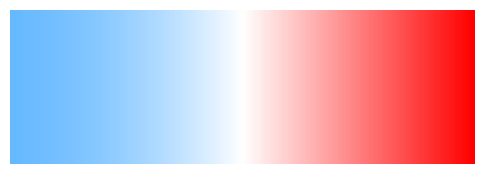

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
# Define the colors at specific points
colors = [
    # (0, "#120041"),  # Start with blue at -1.9
    # (0, "#2500fa"),
    (0, "#84c6fd"),  # Start with blue at -1.9
    (0.33, "white"),    # Transition to white at 0
    # (0.6, "#ffa300"),
    # (0.4, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (0, to_rgba("#120041", alpha=1.0)),  # Fully opaque
    # (0, to_rgba("#2500fa", alpha=0.8)),  # Fully opaque
    (0, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0.33, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.6, to_rgba("#ffa300", alpha=1.0)),   # 30% opacity
    # (0.4, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.0, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0, 1, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()



## load nifti files

`scripts/step12_multiclass/mask_singletrial.py` <br>
`scripts/step12_multiclass/mask_singletrial.sh`

# load data

In [3]:
# once the voxels values are extracted
data_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv02_parcel-NPS'
npy_nps = np.load(join(data_dir, "npspos_dACC_event-stimulus.npy"))
npy_nps_metadata = join(data_dir, "npspos_dACC_event-stimulus.json")
with open(npy_nps_metadata, 'r') as file:
    npy_nps_meta = json.load(file)
# feed it through the SVM pipeline

In [7]:
# load numpy
# load json file with metadata

# combine as pandas
# npsneg_lLOC = np.vstack(masked_niftiarray)
npsneg_lLOC = npy_nps
singletrial_fname = npy_nps_meta['filenames']
npspos_dACC = pd.DataFrame({'singletrial_fname': singletrial_fname})

def extract_metadata(filename):
    pattern = re.compile(
        r"(?P<sub>sub-\d+)_"
        r"(?P<ses>ses-\d+)_"
        r"(?P<run>run-\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"(?P<trial>trial-\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimulusintensity>\w+)"
    )
    match = pattern.search(filename)
    if match:
        
        metadata = match.groupdict()
        metadata['cue'] = metadata['cuetype'] + '_cue'
        metadata['stim'] = metadata['stimulusintensity'] + '_stim'
        return metadata
    
    return {}
metadata_df = pd.DataFrame(npspos_dACC['singletrial_fname'].apply(extract_metadata).tolist())
metadata_df = pd.concat([metadata_df, npspos_dACC], axis=1)


prefix = "NPSpos_dACC_"
columns = [prefix + str(i) for i in range(npsneg_lLOC.shape[1])]
arraydf = pd.DataFrame(npsneg_lLOC, columns=columns)

npspos_dACC = pd.concat([metadata_df, arraydf], axis=1)

In [8]:
metadata_df['singletrial_fname'][3]

'sub-0002_ses-04_run-05_runtype-cognitive_event-stimulus_trial-006_cuetype-low_stimintensity-high.nii.gz'

In [9]:
npspos_dACC

,sub,ses,run,runtype,event,trial,cuetype,stimulusintensity,cue,stim,...,NPSpos_dACC_172,NPSpos_dACC_173,NPSpos_dACC_174,NPSpos_dACC_175,NPSpos_dACC_176,NPSpos_dACC_177,NPSpos_dACC_178,NPSpos_dACC_179,NPSpos_dACC_180,NPSpos_dACC_181
0,sub-0002,ses-03,run-02,pain,stimulus,trial-009,high,high,high_cue,high_stim,...,1.388228,0.904351,-0.255798,-0.263679,-0.030048,0.071986,0.888774,0.464462,1.214903,0.777590
1,sub-0002,ses-04,run-05,cognitive,stimulus,trial-010,low,med,low_cue,med_stim,...,-0.238658,-0.336323,0.301502,-0.011044,0.134401,-0.113778,-0.072287,-0.104584,-0.412053,-0.478856
2,sub-0002,ses-04,run-02,cognitive,stimulus,trial-005,low,low,low_cue,low_stim,...,0.650335,0.942116,0.510449,0.730210,0.573041,0.723064,0.386306,0.541142,0.559737,0.767509
3,sub-0002,ses-04,run-05,cognitive,stimulus,trial-006,low,high,low_cue,high_stim,...,0.182327,0.333341,0.120561,-0.026085,0.106933,-0.019725,-0.143775,-0.050420,-0.166975,-0.173536
4,sub-0002,ses-03,run-03,cognitive,stimulus,trial-007,high,high,high_cue,high_stim,...,0.803049,0.759632,-0.189801,-0.150728,-0.156958,-0.084024,0.305832,0.234135,0.815478,0.763881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17106,sub-0133,ses-04,run-02,pain,stimulus,trial-008,high,high,high_cue,high_stim,...,0.471998,0.731039,0.210806,0.236812,0.192283,0.302114,0.194005,0.279914,0.516217,0.705958
17107,sub-0133,ses-04,run-03,vicarious,stimulus,trial-008,low,med,low_cue,med_stim,...,0.539269,0.826191,0.239379,-0.022515,0.204048,0.103741,0.544395,0.593226,0.824838,0.948978
17108,sub-0133,ses-03,run-04,cognitive,stimulus,trial-000,high,low,high_cue,low_stim,...,1.271826,2.075302,0.572015,0.459538,0.913633,0.773790,1.183248,1.478207,1.582399,2.033468
17109,sub-0133,ses-03,run-05,vicarious,stimulus,trial-001,high,med,high_cue,med_stim,...,0.427253,0.620623,0.243672,-0.080139,0.145775,0.039234,0.283725,0.347326,0.566183,0.712040


In [10]:
# Define the mapping
mapping = {'low_stim': 0, 'med_stim': 1, 'high_stim': 2}
npspos_dACC['stim_num'] = npspos_dACC['stim'].map(mapping)


In [11]:
npspos_dACC

,sub,ses,run,runtype,event,trial,cuetype,stimulusintensity,cue,stim,...,NPSpos_dACC_173,NPSpos_dACC_174,NPSpos_dACC_175,NPSpos_dACC_176,NPSpos_dACC_177,NPSpos_dACC_178,NPSpos_dACC_179,NPSpos_dACC_180,NPSpos_dACC_181,stim_num
0,sub-0002,ses-03,run-02,pain,stimulus,trial-009,high,high,high_cue,high_stim,...,0.904351,-0.255798,-0.263679,-0.030048,0.071986,0.888774,0.464462,1.214903,0.777590,2
1,sub-0002,ses-04,run-05,cognitive,stimulus,trial-010,low,med,low_cue,med_stim,...,-0.336323,0.301502,-0.011044,0.134401,-0.113778,-0.072287,-0.104584,-0.412053,-0.478856,1
2,sub-0002,ses-04,run-02,cognitive,stimulus,trial-005,low,low,low_cue,low_stim,...,0.942116,0.510449,0.730210,0.573041,0.723064,0.386306,0.541142,0.559737,0.767509,0
3,sub-0002,ses-04,run-05,cognitive,stimulus,trial-006,low,high,low_cue,high_stim,...,0.333341,0.120561,-0.026085,0.106933,-0.019725,-0.143775,-0.050420,-0.166975,-0.173536,2
4,sub-0002,ses-03,run-03,cognitive,stimulus,trial-007,high,high,high_cue,high_stim,...,0.759632,-0.189801,-0.150728,-0.156958,-0.084024,0.305832,0.234135,0.815478,0.763881,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17106,sub-0133,ses-04,run-02,pain,stimulus,trial-008,high,high,high_cue,high_stim,...,0.731039,0.210806,0.236812,0.192283,0.302114,0.194005,0.279914,0.516217,0.705958,2
17107,sub-0133,ses-04,run-03,vicarious,stimulus,trial-008,low,med,low_cue,med_stim,...,0.826191,0.239379,-0.022515,0.204048,0.103741,0.544395,0.593226,0.824838,0.948978,1
17108,sub-0133,ses-03,run-04,cognitive,stimulus,trial-000,high,low,high_cue,low_stim,...,2.075302,0.572015,0.459538,0.913633,0.773790,1.183248,1.478207,1.582399,2.033468,0
17109,sub-0133,ses-03,run-05,vicarious,stimulus,trial-001,high,med,high_cue,med_stim,...,0.620623,0.243672,-0.080139,0.145775,0.039234,0.283725,0.347326,0.566183,0.712040,1


# dpINS average activation

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

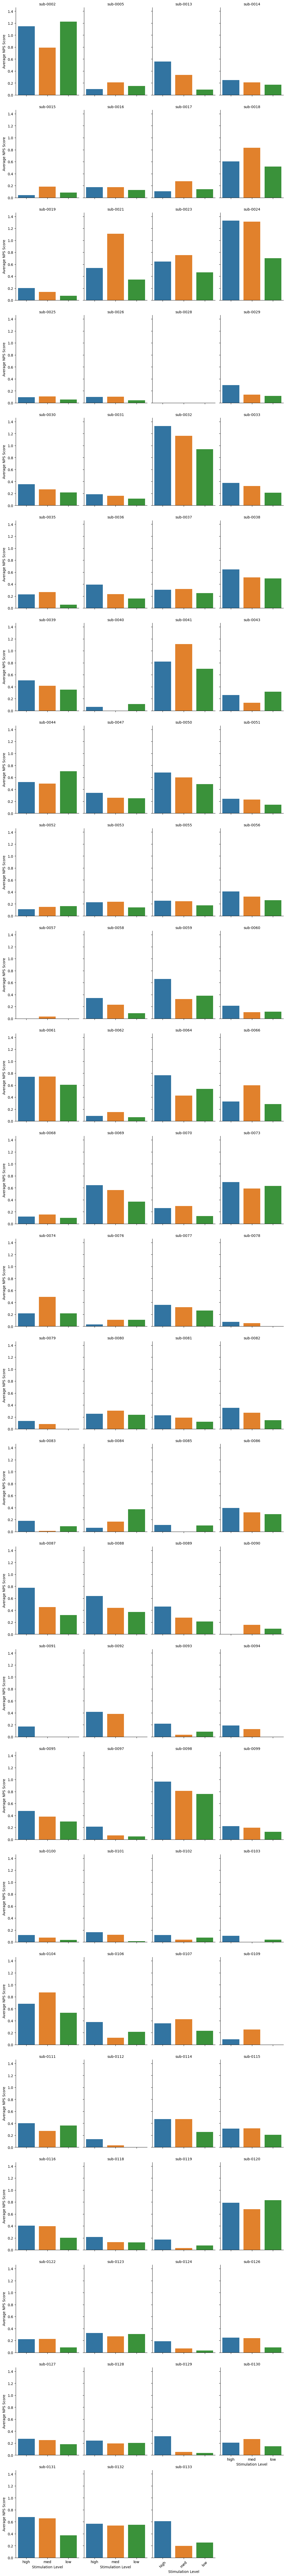

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cuetype='high_cue'
df_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') 
                                    # (npspos_dpINS['ses'] == 'ses-01')
                                    # (npspos_dpINS['cue'] == cuetype) 
                                    ].index
df_pain = npspos_dACC[(npspos_dACC['runtype'] == 'pain') 
                                # ((npspos_dpINS['ses'] == 'ses-01')) 
                                # (npspos_dpINS['cue'] == cuetype)
                                ].copy().reset_index(drop=True)

# Step 1: Compute the row-wise mean of the NPS scores
df_pain['NPS_mean'] = df_pain.filter(regex=r'^NPSpos_dACC_\d+').mean(axis=1)

# Step 2: Aggregate data to compute the mean NPS score per 'stim' for each 'sub'
grouped_data = df_pain.groupby(['sub', 'stimulusintensity'])['NPS_mean'].mean().reset_index()

# Step 3: Adjust order of 'stim' levels
stim_order = ['high', 'med', 'low']
grouped_data['stimulusintensity'] = pd.Categorical(grouped_data['stimulusintensity'], categories=stim_order, ordered=True)

# Now, grouped_data is ready for plotting
# Step 4: Plot
g = sns.catplot(x='stimulusintensity', y='NPS_mean', col='sub', data=grouped_data, kind='bar',
                height=4, aspect=.7, col_wrap=4, order=stim_order)

# Optional: Adjust plot aesthetics
g.set_axis_labels("Stimulation Level", "Average NPS Score")
g.set_titles("{col_name}")
g.set(ylim=(0, grouped_data['NPS_mean'].max()*1.1)) # Adjust y-axis limits if necessary
plt.xticks(rotation=45) # Rotate x-axis labels if needed

plt.show()


## expected vs unexpected

In [13]:
ratings = pd.read_csv('/Users/h/Documents/projects_local/cue_expectancy/data/beh/sub-all_task-all_events.tsv', sep = '\t')
ratings

def parse_filename_with_regex_adjusted(filename):
    # Updated regular expression pattern to keep the prefixes in the extracted values
    pattern = r"(sub-\d+)_(ses-\d+)_(run-\d+)_runtype-(\w+)_event-(\w+)_trial-(\d+)_cuetype-(\w+)_stimintensity-(\w+)"
    match = re.match(pattern, filename)
    
    if match:
        metadata = {
            'sub': match.group(1),  # Keeping the prefix for sub
            'ses':  match.group(2),  # Adding 'ses-' prefix
            'run':  match.group(3),  # Adding 'run-' prefix
            'runtype': match.group(4),
            'event': match.group(5),
            'trial_index': int(match.group(6)),  # Convert trial_index to integer
            'cue': match.group(7) + '_cue',  # Append "_cue" to cue value
            'stimulusintensity': match.group(8),  # Append "_stim" to stimulusintensity value
        }
        return metadata
    else:
        return {}

# Test the adjusted function with the sample filename
ratings_parsed = (ratings['singletrial_fname']).apply(parse_filename_with_regex_adjusted).apply(pd.Series)
rating_merge = pd.concat([ratings[['singletrial_fname', 'expectrating', 'outcomerating']], ratings_parsed], axis=1)

npspos_dACC['trial_index'] = npspos_dACC['trial'].str.extract('(\d+)').astype(int)

brain_metadf = pd.merge(rating_merge, npspos_dACC, on=[ "sub", "ses", "run", "runtype", "trial_index", "cue", "stimulusintensity"], how="inner")

In [14]:
npspos_dACC

,sub,ses,run,runtype,event,trial,cuetype,stimulusintensity,cue,stim,...,NPSpos_dACC_174,NPSpos_dACC_175,NPSpos_dACC_176,NPSpos_dACC_177,NPSpos_dACC_178,NPSpos_dACC_179,NPSpos_dACC_180,NPSpos_dACC_181,stim_num,trial_index
0,sub-0002,ses-03,run-02,pain,stimulus,trial-009,high,high,high_cue,high_stim,...,-0.255798,-0.263679,-0.030048,0.071986,0.888774,0.464462,1.214903,0.777590,2,9
1,sub-0002,ses-04,run-05,cognitive,stimulus,trial-010,low,med,low_cue,med_stim,...,0.301502,-0.011044,0.134401,-0.113778,-0.072287,-0.104584,-0.412053,-0.478856,1,10
2,sub-0002,ses-04,run-02,cognitive,stimulus,trial-005,low,low,low_cue,low_stim,...,0.510449,0.730210,0.573041,0.723064,0.386306,0.541142,0.559737,0.767509,0,5
3,sub-0002,ses-04,run-05,cognitive,stimulus,trial-006,low,high,low_cue,high_stim,...,0.120561,-0.026085,0.106933,-0.019725,-0.143775,-0.050420,-0.166975,-0.173536,2,6
4,sub-0002,ses-03,run-03,cognitive,stimulus,trial-007,high,high,high_cue,high_stim,...,-0.189801,-0.150728,-0.156958,-0.084024,0.305832,0.234135,0.815478,0.763881,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17106,sub-0133,ses-04,run-02,pain,stimulus,trial-008,high,high,high_cue,high_stim,...,0.210806,0.236812,0.192283,0.302114,0.194005,0.279914,0.516217,0.705958,2,8
17107,sub-0133,ses-04,run-03,vicarious,stimulus,trial-008,low,med,low_cue,med_stim,...,0.239379,-0.022515,0.204048,0.103741,0.544395,0.593226,0.824838,0.948978,1,8
17108,sub-0133,ses-03,run-04,cognitive,stimulus,trial-000,high,low,high_cue,low_stim,...,0.572015,0.459538,0.913633,0.773790,1.183248,1.478207,1.582399,2.033468,0,0
17109,sub-0133,ses-03,run-05,vicarious,stimulus,trial-001,high,med,high_cue,med_stim,...,0.243672,-0.080139,0.145775,0.039234,0.283725,0.347326,0.566183,0.712040,1,1


# hyperparameter + classes weighted

## combined cues

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_97925/3205017266.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['ses_run'] =  df_filtered['ses'] + '_' + df_filtered['run']
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_97925/3205017266.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['ses_run'] =  df_filtered['ses'] + '_' + df_filtered['run']
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_97925/3205017266.py:23: SettingWithCopyWarning: 
A value is t

         sub  accuracy  f1_score
0   sub-0005  0.333333  0.308285
1   sub-0013  0.291667  0.252513
2   sub-0014  0.312500  0.262932
3   sub-0015  0.250000  0.196544
4   sub-0016  0.419048  0.416681
..       ...       ...       ...
90  sub-0129  0.381313  0.347150
91  sub-0130  0.361111  0.332764
92  sub-0131  0.375000  0.326020
93  sub-0132  0.405556  0.344444
94  sub-0133  0.416667  0.404105

[95 rows x 3 columns]


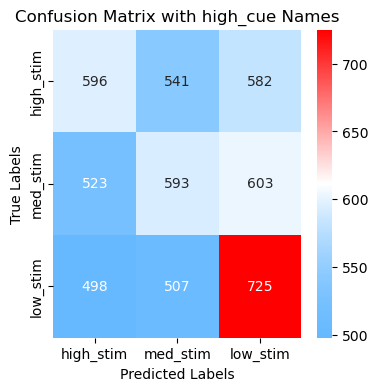

Normalized Confusion Matrix (by Actual Class Totals):
[[0.34671321 0.31471786 0.33856894]
 [0.30424666 0.344968   0.35078534]
 [0.28786127 0.29306358 0.41907514]]


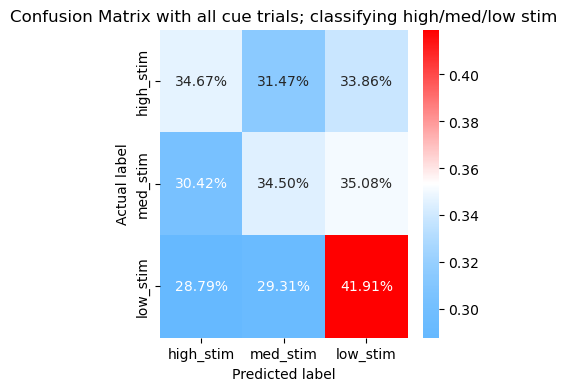

In [16]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd


# subset pain data with high cue trials ________________________________________
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') 
                                    ].index
df_pain_highcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain')].copy().reset_index(drop=True)
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

overall_results = []
all_Y_test = []
all_Y_pred = []
# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    df_sub['ses_run'] =  df_filtered['ses'] + '_' + df_filtered['run'] 
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
###
    sub_accuracies = []
    accuracies = []
    f1_scores = []
    test_indices = []
    predictions = []
    sub_predictions = []
    sub_true = []
    sub_f1_scores = []
    groups, _ = pd.factorize(df_sub['ses_run'])
    
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # Initialize and train the SVM model
        svc = SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr')
        # Perform GridSearchCV for hyperparameter tuning
        svc.fit(X_train, Y_train)
        Y_pred = svc.predict(X_test)
        sub_true.extend(Y_test)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test, Y_pred))
        sub_f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))

        # Store the test index and predictions
        test_indices.extend(test_idx)
        accuracies.append(accuracy_score(Y_test, Y_pred))
        f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)     
    mean_f1_score = np.mean(f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# _____________ confusion matrix ________________________________________________
# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]

# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
# Calculate precision, recall, and F1 scores
precision, recall, f1, _ = precision_recall_fscore_support(Y_test_remapped, Y_pred_remapped, average=None)
accuracy = np.diag(cm).sum() / cm.sum()
conf_matrix_df = pd.DataFrame(cm, index=desired_class_order, columns=desired_class_order)


# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with all cue trials; classifying high/med/low stim')
plt.show()





In [18]:
results_df['accuracy'].mean()

0.3621599200020253

## high cue

## no grid search

In [47]:
npspos_dACC.head()

,sub,ses,run,runtype,event,trial,cuetype,stimulusintensity,cue,stim,...,NPSpos_dACC_175,NPSpos_dACC_176,NPSpos_dACC_177,NPSpos_dACC_178,NPSpos_dACC_179,NPSpos_dACC_180,NPSpos_dACC_181,stim_num,trial_index,ses_run
0,sub-0002,ses-03,run-02,pain,stimulus,trial-009,high,high,high_cue,high_stim,...,-0.263679,-0.030048,0.071986,0.888774,0.464462,1.214903,0.777590,2,9,ses-03_run-02
1,sub-0002,ses-04,run-05,cognitive,stimulus,trial-010,low,med,low_cue,med_stim,...,-0.011044,0.134401,-0.113778,-0.072287,-0.104584,-0.412053,-0.478856,1,10,ses-04_run-05
2,sub-0002,ses-04,run-02,cognitive,stimulus,trial-005,low,low,low_cue,low_stim,...,0.730210,0.573041,0.723064,0.386306,0.541142,0.559737,0.767509,0,5,ses-04_run-02
3,sub-0002,ses-04,run-05,cognitive,stimulus,trial-006,low,high,low_cue,high_stim,...,-0.026085,0.106933,-0.019725,-0.143775,-0.050420,-0.166975,-0.173536,2,6,ses-04_run-05
4,sub-0002,ses-03,run-03,cognitive,stimulus,trial-007,high,high,high_cue,high_stim,...,-0.150728,-0.156958,-0.084024,0.305832,0.234135,0.815478,0.763881,2,7,ses-03_run-03


In [48]:
# Unique subjects before filtering
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                    (npspos_dACC['cue'] == cuetype)].index
df_pain_highcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                (npspos_dACC['cue'] == cuetype)].copy().reset_index(drop=True)
unique_subs_before = npspos_dACC['sub'].unique()

# Apply filtering
df_pain_highcue['ses_run'] = df_pain_highcue['ses'] + '_' + df_pain_highcue['run']
filtered_df = df_pain_highcue.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) >= 2)

# Unique subjects after filtering
unique_subs_after = filtered_df['sub'].unique()

# Find the difference
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]

# Number of unique subjects dropped
num_subs_dropped = len(subs_dropped)

# Print the number and optionally the IDs of the dropped subjects
print(f"Number of unique subjects dropped: {num_subs_dropped}")
# Print the number and optionally the IDs of the dropped subjects
print(f"Number of unique subjects dropped: {num_subs_dropped}")
if num_subs_dropped > 0:
    print("IDs of dropped subjects:", subs_dropped)
else:
    print("No subjects were dropped.")

# Return the number and list of dropped subjects for further use if needed
num_subs_dropped, subs_dropped

Number of unique subjects dropped: 2
Number of unique subjects dropped: 2
IDs of dropped subjects: ['sub-0071', 'sub-0075']


(2, ['sub-0071', 'sub-0075'])

Number of unique subjects dropped: 30
[0 1 2 0 1 2 1 2 1 2 2 0 2 1 1 0 1 1 0 0 0 0 2 2]
[0 1 2 2 0 1 1 2 1 0 2 1 0 1 0 0 2 2 1 2 0 2 1 0]
[0 0 1 1 0 1 2 2 2 1 2 0 2 0 0 1 2 2 2 1 0 0 1 1]
[0 0 1 0 2 1 1 1 2 2 2 0]
[0 1 2 0 0 2 1 2 1 0 1 2]
[0 0 0 0 1 2 1 2 0 2 1 1 0 1 2 2 1 1 2 0 2 1 2 0]
[0 1 0 2 2 1 0 2 0 2 1 2 0 1 1 0 2 1]
[0 1 2 0 2 2 1 2 2 2 1 0 1 1 2 1 0 0 1 1 0 0 0 2]
[0 1 1 2 1 0 2 0 2 1 0 2 2 0 0 1 2 1 1 1 0 1 0 0 2 2 1 0 0 1 1 2 2 2 2 0]
[0 0 0 1 2 2 2 2 1 1 0 2 2 1 0 1 2 0 1 2 0 1 1 0]
[0 0 0 1 2 2 2 2 1 1 0 1]
[0 1 0 2 0 2 2 2 2 2 2 1 2 0 1 0 0 1 1 1 1 1 0 0 1 1 2 0 2 1 0 0 2 2 0 1]
[0 1 0 0 2 2 0 1 2 1 1 2]
[0 1 1 1 1 2 2 0 1 2 0 0 0 2 1 2 1 0 0 0 0 0 1 2 1 1 2 2 2 1 2 2 2 1 0 0]
[0 1 0 1 0 0 1 2 0 2 0 2 1 2 2 0 1 1 1 2 0 2 1 0 1 0 2 1 2 2 2 1 0 0 2 1]
[0 1 0 2 2 1 0 0 1 0 2 0 1 2 2 0 2 1 2 2 0 1 1 1]
[0 1 1 2 0 2 0 1 2 1 0 1 2 0 2 1 1 2 0 0 1 0 2 2 1 2 0 0 2 1 2 1 2 1 0 0]
[0 0 1 1 1 2 2 2 1 1 2 0 1 0 0 1 2 0 1 2 0 2 2 0 0 0 0 1 1 2 2 2 1 2 0 1]
[0 0 0 1 1 2 1 0 0 1 0 1 2

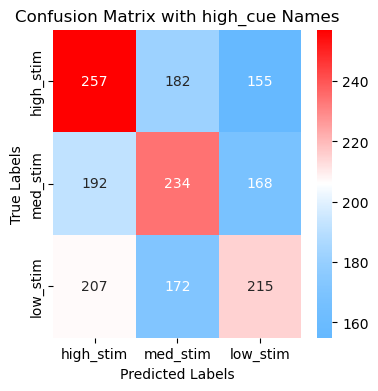

Normalized Confusion Matrix (by Actual Class Totals):
[[0.43265993 0.30639731 0.26094276]
 [0.32323232 0.39393939 0.28282828]
 [0.34848485 0.28956229 0.36195286]]


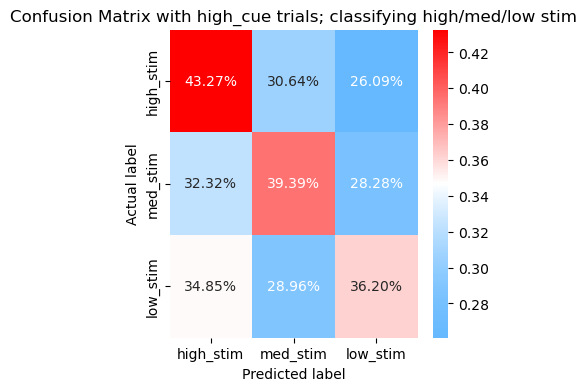

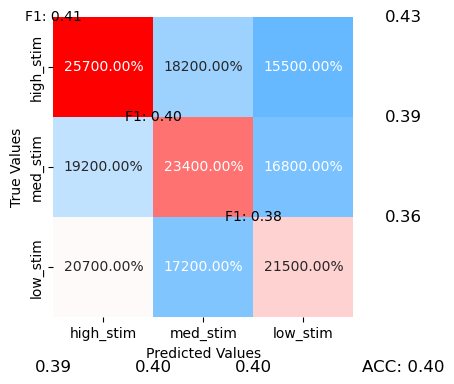

In [116]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd

cuetype = 'high_cue'
# Step 1: subset pain data with high cue trials ________________________________
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                    (npspos_dACC['cue'] == cuetype)].index
df_pain_highcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                (npspos_dACC['cue'] == cuetype)].copy().reset_index(drop=True)


# Step 2: filter dataframe based on stimulus intensity trials per sub/ses ______
# Ensure that for each subject (sub), within, each session-run combination (ses_run), 
# there are at least two trials for each level of stimulus intensity (stimulusintensity). 
# This step aims to exclude subjects or trials that don't meet this criterion, 
# ensuring a minimum level of data availability for each condition.
df_pain_highcue['ses_run'] =  df_pain_highcue['ses'] + '_' + df_pain_highcue['run'] 
# Correcting the approach to identify participants to exclude
filtered_groups = df_pain_highcue.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) < 2)
participants_to_exclude = filtered_groups['sub'].unique()
filtered_df = df_pain_highcue[~df_pain_highcue['sub'].isin(participants_to_exclude)]


# Step 3: How many subjects would be dropped after this filtering? _____________
unique_subs_after = filtered_df['sub'].unique()
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]
num_subs_dropped = len(subs_dropped)
print(f"Number of unique subjects dropped: {num_subs_dropped}")

# Step 4: group level arrays
runs_per_sub = filtered_df.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = filtered_df[~filtered_df['sub'].isin(subs_to_drop)]
confusion_matrices = []
overall_results = []
all_Y_test = []
all_Y_pred = []
normalized_matrices = []
# Step 5: Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    print(Y)
    # 5-1. subject wise items to save __________________________________________
    # Initialization: Set up structures to store subject-specific metrics like 
    # accuracy and F1 scores, along with confusion matrices for later analysis.
    sub_accuracies = []
    accuracies = []
    f1_scores = []
    test_indices = []
    predictions = []
    sub_predictions = []
    sub_true = []
    sub_f1_scores = []
    sub_confusion_matrices = [] 
    # 5-2. K fold per run (unique session/run combination) _____________________
    groups, unique_runs = pd.factorize(df_sub['ses_run'])
    
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # 5-3. Initialize and train the SVM model ______________________________
        svc = SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr')
        svc.fit(X_train, Y_train)#, groups_train) #, groups=groups_train)
        Y_pred = svc.predict(X_test)

        sub_true.extend(Y_test)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test, Y_pred))
        sub_f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))


        # 5-4. Store the test index and predictions ____________________________
        test_indices.extend(test_idx)
        # Calculate confusion matrix for the current fold and add it to the list
        cm = confusion_matrix(Y_test, Y_pred)
        sub_confusion_matrices.append(cm)
        
        # Predict and evaluate
        accuracies.append(accuracy_score(Y_test, Y_pred))
        f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)     
    mean_f1_score = np.mean(f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})
    # Aggregate the confusion matrices for this subject by summing them
    sub_cm_sum = np.sum(sub_confusion_matrices, axis=0)
    sub_cm_normalized = sub_cm_sum / sub_cm_sum.sum(axis=1, keepdims=True)
    confusion_matrices.append(sub_cm_sum)

        # Normalize the summed confusion matrix for this subject
    with np.errstate(invalid='ignore', divide='ignore'):
        sub_cm_normalized = sub_cm_sum / sub_cm_sum.sum(axis=1, keepdims=True)
        sub_cm_normalized[np.isnan(sub_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

    normalized_matrices.append(sub_cm_normalized)

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)


# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# _____________ confusion matrix ________________________________________________

# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
# Calculate precision, recall, and F1 scores
precision, recall, f1, _ = precision_recall_fscore_support(Y_test_remapped, Y_pred_remapped, average=None)

# Calculate overall accuracy
accuracy = np.diag(cm).sum() / cm.sum()

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(cm, index=desired_class_order, columns=desired_class_order)


# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()



# Create the heatmap
plt.figure(figsize=(5,5))

heatmap = sns.heatmap(conf_matrix_df, annot=True, fmt=".2%", cmap=cmap, 
                      cbar=False, xticklabels=desired_class_order, yticklabels=desired_class_order)

# Annotate with precision, recall, and F1
for i, label in enumerate(desired_class_order):
    heatmap.text(3.5, i, f"{recall[i]:.2f}", ha='center', va='center', fontsize=12)  # Recall per row
    heatmap.text(i, 3.5, f"{precision[i]:.2f}", ha='center', va='center', fontsize=12)  # Precision per column
    heatmap.text(i, i, f"F1: {f1[i]:.2f}", ha='center', va='center', color='black')  # F1 on the diagonal

# Annotate with overall accuracy
heatmap.text(3.5, 3.5, f"ACC: {accuracy:.2f}", ha='center', va='center', fontsize=12)

# Adjust layout to make room for the annotations
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.3)

# Labels for the true and predicted axes
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

plt.show()



## new confusion matrix scheme (high cue)

Number of unique subjects dropped: 30
[1 2 0 1 2 0 2 0 2 0 0 1 0 2 2 1 2 2 1 1 1 1 0 0]
[2 0 1 1 2 0 0 1 0 2 1 0 2 0 2 2 1 1 0 1 2 1 0 2]
[1 1 0 0 1 0 2 2 2 0 2 1 2 1 1 0 2 2 2 0 1 1 0 0]
[0 0 1 0 2 1 1 1 2 2 2 0]
[2 0 1 2 2 1 0 1 0 2 0 1]
[1 1 1 1 2 0 2 0 1 0 2 2 1 2 0 0 2 2 0 1 0 2 0 1]
[0 2 0 1 1 2 0 1 0 1 2 1 0 2 2 0 1 2]
[1 0 2 1 2 2 0 2 2 2 0 1 0 0 2 0 1 1 0 0 1 1 1 2]
[0 2 2 1 2 0 1 0 1 2 0 1 1 0 0 2 1 2 2 2 0 2 0 0 1 1 2 0 0 2 2 1 1 1 1 0]
[1 1 1 0 2 2 2 2 0 0 1 2 2 0 1 0 2 1 0 2 1 0 0 1]
[0 0 0 2 1 1 1 1 2 2 0 2]
[0 2 0 1 0 1 1 1 1 1 1 2 1 0 2 0 0 2 2 2 2 2 0 0 2 2 1 0 1 2 0 0 1 1 0 2]
[2 1 2 2 0 0 2 1 0 1 1 0]
[2 0 0 0 0 1 1 2 0 1 2 2 2 1 0 1 0 2 2 2 2 2 0 1 0 0 1 1 1 0 1 1 1 0 2 2]
[1 2 1 2 1 1 2 0 1 0 1 0 2 0 0 1 2 2 2 0 1 0 2 1 2 1 0 2 0 0 0 2 1 1 0 2]
[1 0 1 2 2 0 1 1 0 1 2 1 0 2 2 1 2 0 2 2 1 0 0 0]
[0 1 1 2 0 2 0 1 2 1 0 1 2 0 2 1 1 2 0 0 1 0 2 2 1 2 0 0 2 1 2 1 2 1 0 0]
[2 2 0 0 0 1 1 1 0 0 1 2 0 2 2 0 1 2 0 1 2 1 1 2 2 2 2 0 0 1 1 1 0 1 2 0]
[1 1 1 2 2 0 2 1 1 2 1 2 0

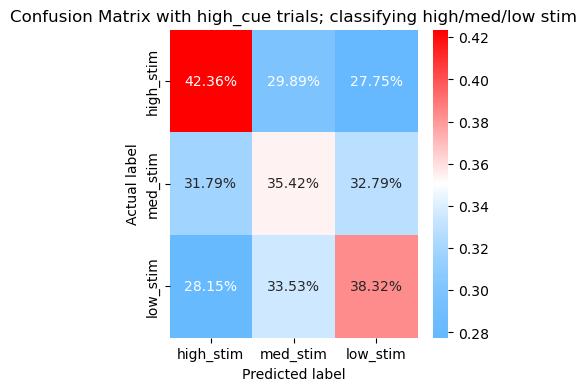

In [119]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd

cuetype = 'high_cue'
# Step 1: subset pain data with high cue trials ________________________________
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                    (npspos_dACC['cue'] == cuetype)].index
df_pain_lowcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                (npspos_dACC['cue'] == cuetype)].copy().reset_index(drop=True)
# Step 2: filter dataframe based on stimulus intensity trials per sub/ses ______
df_pain_lowcue['ses_run'] =  df_pain_lowcue['ses'] + '_' + df_pain_lowcue['run'] 
# Correcting the approach to identify participants to exclude
filtered_groups = df_pain_lowcue.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) < 2)
participants_to_exclude = filtered_groups['sub'].unique()
filtered_df = df_pain_lowcue[~df_pain_lowcue['sub'].isin(participants_to_exclude)]


# Step 3: How many subjects would be dropped after this filtering? _____________
unique_subs_after = filtered_df['sub'].unique()
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]
num_subs_dropped = len(subs_dropped)
print(f"Number of unique subjects dropped: {num_subs_dropped}")

# Step 4: group level arrays
runs_per_sub = filtered_df.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = filtered_df[~filtered_df['sub'].isin(subs_to_drop)]
confusion_matrices = []
overall_results = []
all_Y_test = []
all_Y_pred = []
normalized_matrices = []
desired_order = {'high_stim': 0, 'med_stim': 1, 'low_stim': 2}

# Step 5: Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y_mapped = df_sub['stim'].map(desired_order)
    Y = Y_mapped.values
    uniques = np.array(['high_stim', 'med_stim', 'low_stim'])
    # Y, uniques = pd.factorize(df_sub['stim'])
    print(Y)
    # 5-1. subject wise items to save __________________________________________
    
    # accuracies = []
    # f1_scores = []
    test_indices = []
    predictions = []
    
    sub_true = []; sub_predictions = []; sub_accuracies = []; sub_f1_scores = []
    
    sub_confusion_matrices = [] 
    # 5-2. K fold per run (unique session/run combination) _____________________
    groups, unique_runs = pd.factorize(df_sub['ses_run'])
    
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # 5-3. Initialize and train the SVM model ______________________________
        svc = SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr')

        svc.fit(X_train, Y_train)#, groups_train) #, groups=groups_train)
        Y_pred = svc.predict(X_test)

        sub_true.extend(Y_test)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test, Y_pred))
        sub_f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))

        # 5-4. Store the test index and predictions ____________________________
        test_indices.extend(test_idx)
        cm = confusion_matrix(Y_test, Y_pred)
        cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)
        cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

        sub_confusion_matrices.append(cv_cm_normalized)
        
        # Predict and evaluate
        # accuracies.append(accuracy_score(Y_test, Y_pred))
        # f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(sub_accuracies)     
    mean_f1_score = np.mean(sub_f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})
    # Aggregate the confusion matrices for this subject by summing them
    sub_cm_sum = np.mean(sub_confusion_matrices, axis=0)
    # sub_cm_normalized = sub_cm_sum / sub_cm_sum.sum(axis=1, keepdims=True)
    # confusion_matrices.append(sub_cm_sum)

        # Normalize the summed confusion matrix for this subject
    # with np.errstate(invalid='ignore', divide='ignore'):
    #     sub_cm_normalized = sub_cm_sum / sub_cm_sum.sum(axis=1, keepdims=True)
    #     sub_cm_normalized[np.isnan(sub_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

    normalized_matrices.append(sub_cm_sum) # stack subject average Confusion matrix

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)
desired_class_order = ['high_stim', 'med_stim', 'low_stim']

# confution matrix
average_normalized_cm = np.mean(normalized_matrices, axis=0)
print("Normalized Confusion Matrix (by Actual Class Totals):")
print(average_normalized_cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(average_normalized_cm, 
            annot=True, fmt=".2%", cmap=cmap, 
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()

## Old confusion matrix scheme

# low cue (new method, CM per participant and average)

## map values low cue new method

Number of unique subjects dropped: 32
[1 2 0 1 2 0 1 1 2 0 0 1 1 2 0 1 2 2 2 1 2 0 0 0]
[2 1 0 1 1 1 0 2 1 1 0 2 2 0 2 1 2 0 2 1 2 0 0 0]
[1 0 1 2 1 2 0 2 1 0 2 0 0 1 2 0 0 2 2 0 1 1 1 2]
[2 2 2 1 0 0 2 1 0 0 1 1]
[1 2 0 0 2 2 1 1 0 1 0 2]
[0 0 2 0 2 1 2 0 2 2 2 0 2 0 1 1 1 0 2 0 1 1 1 1]
[1 1 2 2 2 1 0 0 1 0 1 1 0 2 0 0 2 2]
[2 0 0 1 0 1 1 1 2 2 0 2 0 0 2 1 2 0 2 1 1 1 2 0]
[0 1 2 0 2 2 2 1 2 1 0 1 1 2 1 1 2 2 0 0 0 0 0 1]
[1 0 0 0 2 1 1 2 1 0 2 2]
[0 0 1 0 0 1 0 1 0 0 2 2 0 2 1 1 2 2 2 1 2 2 1 0 2 0 0 1 0 1 1 1 2 2 1 2]
[1 0 0 0 2 2 2 1 1 1 2 0]
[0 2 0 0 2 0 2 1 1 1 2 1 1 1 2 1 1 1 2 0 2 0 2 2 2 1 0 1 1 0 0 0 2 0 0 2]
[0 1 0 1 2 1 0 0 2 0 0 1 1 1 0 2 0 2 2 1 1 0 2 2 0 1 1 2 1 2 0 0 1 2]
[1 2 2 2 0 0 0 0 2 1 0 0 0 1 2 0 2 1 0 1 1 1 2 0 2 1 2 0 2 1 1 1 2 1 2 0]
[2 1 2 0 1 2 2 0 1 0 2 1 0 2 2 0 0 2 0 0 2 1 0 1 0 0 2 1 1 1 1 1 2 2 1 0]
[2 0 1 2 0 1 0 0 2 0 1 2 2 0 2 1 2 1 0 2 1 2 2 1 0 2 2 1 0 1 0 1 1 1 0 0]
[1 1 0 2 2 2 1 1 0 2 2 2 1 0 0 0 1 0 0 1 0 1 2 2]
[0 0 1 1 1 2 2 0 1 2 2 0]
[1 1

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_97925/1613034971.py:82: RuntimeWarning: invalid value encountered in divide
  cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)


[1 2 1 0 1 0 1 0 0 2 2 2]
[0 0 2 1 1 0 1 2 1 0 2 2 1 2 2 0 0 0 1 0 2 2 1 1]
[0 1 0 2 0 0 1 1 1 0 0 1 2 2 2 1 0 2 2 1 2 1 0 2 1 0 2 0 2 1]
[0 1 0 2 1 0 2 0 1 2 0 1 1 2 0 1 1 2 2 1 2 2 2 0 0 1 2 1 1 2 0 0 2 1 0 0]
[2 2 0 1 1 2 0 0 1 0 2 2 0 0 2 0 0 1 1 2 1 1 0 2 2 2 0 1 1 0 1 1 2 1 2 0]
[0 0 2 0 1 0 1 2 2 2 1 1 1 1 1 1 1 0 1 2 2 2 0 2 1 0 0 0 2 1 0 0 2 0 2 2]
[1 1 2 2 1 0 0 1 0 1 1 0 2 2 1 2 2 2 0 0 1 0 2 0 2 2 0 2 1 0 1 0 0 2 1 1]
[2 0 2 0 2 0 2 1 1 2 0 0 1 2 0 2 0 0 1 2 2 1 1 0 1 2 1 2 1 2 0 1 1 0 1 0]
[2 1 1 0 2 2 1 0 1 0 0 2]
[0 2 1 0 2 2 1 1 0 1 2 0]
[1 2 2 1 0 0 2 0 1 0 2 1]
[0 2 2 2 1 1 0 1 0 0 1 2]
[0 2 1 2 2 2 0 0 1 0 1 0 2 1 2 1 1 0 1 1 0 0 2 2]
[2 1 0 1 0 2 0 0 0 2 1 0 0 2 2 1 1 1 1 2 0 2 2 1 0 0 2 1 1 1 2 0 0 2 1 2]
[2 0 1 2 1 2 1 0 0 2 1 2 0 1 1 0 1 1 0 0 2 2 2 0]
[0 0 0 0 1 2 2 1 0 1 0 2 2 1 0 1 0 0 0 1 2 1 2 0 1 2 1 2 2 1 2 1 0 2 1 2]
[1 1 2 2 2 0 0 1 0 2 2 1 2 0 1 1 1 0 0 1 2 2 1 0 0 2 0 1 1 2 0 0 0 1 2 2]
[0 0 0 1 1 2 2 1 1 0 2 2]
[1 0 2 1 1 2 0 0 1 2 2 2 1 1 2 0 0 0]
[0

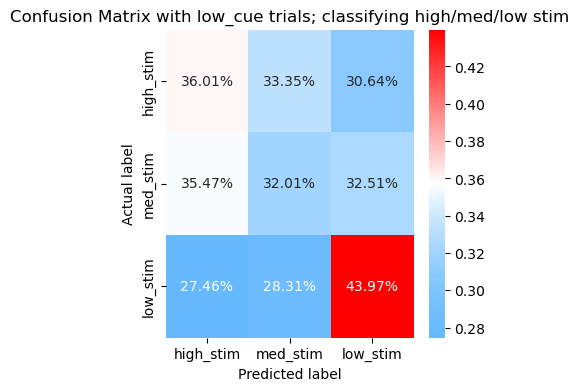

In [120]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd

cuetype = 'low_cue'
# Step 1: subset pain data with high cue trials ________________________________
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                    (npspos_dACC['cue'] == cuetype)].index
df_pain_lowcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                (npspos_dACC['cue'] == cuetype)].copy().reset_index(drop=True)
# Step 2: filter dataframe based on stimulus intensity trials per sub/ses ______
df_pain_lowcue['ses_run'] =  df_pain_lowcue['ses'] + '_' + df_pain_lowcue['run'] 
# Correcting the approach to identify participants to exclude
filtered_groups = df_pain_lowcue.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) < 2)
participants_to_exclude = filtered_groups['sub'].unique()
filtered_df = df_pain_lowcue[~df_pain_lowcue['sub'].isin(participants_to_exclude)]


# Step 3: How many subjects would be dropped after this filtering? _____________
unique_subs_after = filtered_df['sub'].unique()
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]
num_subs_dropped = len(subs_dropped)
print(f"Number of unique subjects dropped: {num_subs_dropped}")

# Step 4: group level arrays
runs_per_sub = filtered_df.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = filtered_df[~filtered_df['sub'].isin(subs_to_drop)]
confusion_matrices = []
overall_results = []
all_Y_test = []
all_Y_pred = []
normalized_matrices = []
desired_order = {'high_stim': 0, 'med_stim': 1, 'low_stim': 2}

# Step 5: Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y_mapped = df_sub['stim'].map(desired_order)
    Y = Y_mapped.values
    uniques = np.array(['high_stim', 'med_stim', 'low_stim'])
    # Y, uniques = pd.factorize(df_sub['stim'])
    print(Y)
    # 5-1. subject wise items to save __________________________________________
    
    # accuracies = []
    # f1_scores = []
    test_indices = []
    predictions = []
    
    sub_true = []; sub_predictions = []; sub_accuracies = []; sub_f1_scores = []
    
    sub_confusion_matrices = [] 
    # 5-2. K fold per run (unique session/run combination) _____________________
    groups, unique_runs = pd.factorize(df_sub['ses_run'])
    
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # 5-3. Initialize and train the SVM model ______________________________
        svc = SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr')

        svc.fit(X_train, Y_train)#, groups_train) #, groups=groups_train)
        Y_pred = svc.predict(X_test)

        sub_true.extend(Y_test)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test, Y_pred))
        sub_f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))

        # 5-4. Store the test index and predictions ____________________________
        test_indices.extend(test_idx)
        cm = confusion_matrix(Y_test, Y_pred)
        cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)
        cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

        sub_confusion_matrices.append(cv_cm_normalized)
        
        # Predict and evaluate
        # accuracies.append(accuracy_score(Y_test, Y_pred))
        # f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(sub_accuracies)     
    mean_f1_score = np.mean(sub_f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})
    # Aggregate the confusion matrices for this subject by summing them
    sub_cm_sum = np.mean(sub_confusion_matrices, axis=0)
    # sub_cm_normalized = sub_cm_sum / sub_cm_sum.sum(axis=1, keepdims=True)
    # confusion_matrices.append(sub_cm_sum)

        # Normalize the summed confusion matrix for this subject
    # with np.errstate(invalid='ignore', divide='ignore'):
    #     sub_cm_normalized = sub_cm_sum / sub_cm_sum.sum(axis=1, keepdims=True)
    #     sub_cm_normalized[np.isnan(sub_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

    normalized_matrices.append(sub_cm_sum) # stack subject average Confusion matrix

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)
desired_class_order = ['high_stim', 'med_stim', 'low_stim']

# confution matrix
average_normalized_cm = np.mean(normalized_matrices, axis=0)
print("Normalized Confusion Matrix (by Actual Class Totals):")
print(average_normalized_cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(average_normalized_cm, 
            annot=True, fmt=".2%", cmap=cmap, 
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()

# low cue (old method, extend CM)

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_97925/2844689953.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['ses_run'] =  df_filtered['ses'] + '_' + df_filtered['run']
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_97925/2844689953.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['ses_run'] =  df_filtered['ses'] + '_' + df_filtered['run']
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_97925/2844689953.py:24: SettingWithCopyWarning: 
A value is t

         sub  accuracy  f1_score
0   sub-0005  0.375000  0.334921
1   sub-0013  0.416667  0.328175
2   sub-0014  0.208333  0.175000
3   sub-0015  0.250000  0.142857
4   sub-0016  0.433333  0.442222
..       ...       ...       ...
90  sub-0129  0.400000  0.357407
91  sub-0130  0.416667  0.361111
92  sub-0131  0.416667  0.353175
93  sub-0132  0.133333  0.093333
94  sub-0133  0.555556  0.511376

[95 rows x 3 columns]


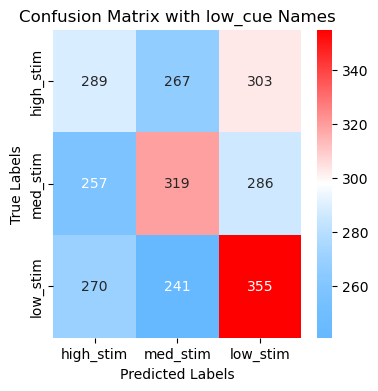

Normalized Confusion Matrix (by Actual Class Totals):
[[0.33643772 0.31082654 0.35273574]
 [0.29814385 0.37006961 0.33178654]
 [0.31177829 0.27829099 0.40993072]]


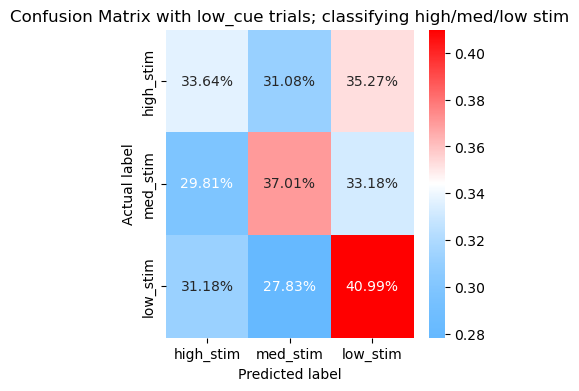

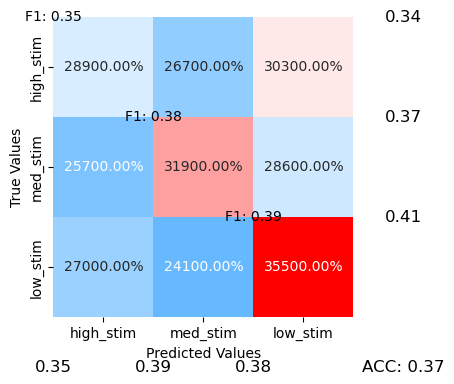

In [88]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd

cuetype = 'low_cue'
# subset pain data with high cue trials ________________________________________
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                    (npspos_dACC['cue'] == cuetype)].index
df_pain_highcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                (npspos_dACC['cue'] == cuetype)].copy().reset_index(drop=True)
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

overall_results = []
all_Y_test = []
all_Y_pred = []
# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    df_sub['ses_run'] =  df_filtered['ses'] + '_' + df_filtered['run'] 
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
###
    sub_accuracies = []
    accuracies = []
    f1_scores = []
    test_indices = []
    predictions = []
    sub_predictions = []
    sub_true = []
    sub_f1_scores = []
    groups, _ = pd.factorize(df_sub['ses_run'])
    
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # Initialize and train the SVM model
        svc = SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr')

        svc.fit(X_train, Y_train)#, groups_train) #, groups=groups_train)
        Y_pred = svc.predict(X_test)

        sub_true.extend(Y_test)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test, Y_pred))
        sub_f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        test_indices.extend(test_idx)
        accuracies.append(accuracy_score(Y_test, Y_pred))
        f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)     
    mean_f1_score = np.mean(f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})


# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# _____________ confusion matrix ________________________________________________

# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
# Calculate precision, recall, and F1 scores
precision, recall, f1, _ = precision_recall_fscore_support(Y_test_remapped, Y_pred_remapped, average=None)

# Calculate overall accuracy
accuracy = np.diag(cm).sum() / cm.sum()

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(cm, index=desired_class_order, columns=desired_class_order)


# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()



# Create the heatmap
plt.figure(figsize=(5,5))

heatmap = sns.heatmap(conf_matrix_df, annot=True, fmt=".2%", cmap=cmap, 
                      cbar=False, xticklabels=desired_class_order, yticklabels=desired_class_order)

# Annotate with precision, recall, and F1
for i, label in enumerate(desired_class_order):
    heatmap.text(3.5, i, f"{recall[i]:.2f}", ha='center', va='center', fontsize=12)  # Recall per row
    heatmap.text(i, 3.5, f"{precision[i]:.2f}", ha='center', va='center', fontsize=12)  # Precision per column
    heatmap.text(i, i, f"F1: {f1[i]:.2f}", ha='center', va='center', color='black')  # F1 on the diagonal

# Annotate with overall accuracy
heatmap.text(3.5, 3.5, f"ACC: {accuracy:.2f}", ha='center', va='center', fontsize=12)

# Adjust layout to make room for the annotations
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.3)

# Labels for the true and predicted axes
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

plt.show()


## debug grid search

In [22]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd

cuetype = 'high_cue'
# Setup your data and groups as before
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                    # (npspos_dpINS['ses'] == "ses-04") &
                                    (npspos_dACC['cue'] == cuetype)].index
df_pain_highcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                # (npspos_dpINS['ses'] == "ses-04") &
                                (npspos_dACC['cue'] == cuetype)].copy().reset_index(drop=True)
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Example hyperparameters
    'svc__kernel': ['linear']  # Adjust as needed
}

# Define the scoring function
scoring = {'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average='weighted')}

overall_results = []

# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    df_sub['ses_run'] =  df_filtered['ses'] + '_' + df_filtered['run'] 
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
###
    accuracies = []
    f1_scores = []
    test_indices = []
    predictions = []
    sub_predictions = []
    sub_true = []
    groups, _ = pd.factorize(df_sub['ses_run'])
    
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # Initialize and train the SVM model
        svc = SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr')
        # Perform GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(svc, param_grid, scoring=scoring, refit='F1', cv=cv)  # Inner CV for hyperparameter tuning
        # grid_search.fit(X_train, Y_train, groups=groups_train)
        grid_search.fit(X_train, Y_train, groups_train) #, groups=groups_train)
        Y_pred = grid_search.best_estimator_.predict(X_test)
        sub_predictions.extend(Y_pred)
        sub_true.extend(Y_test)
        # Store the test index and predictions
        test_indices.extend(test_idx)
        predictions.extend(grid_search.predict(X_test))
    f1 = f1_score(Y[test_indices], predictions, average='weighted')
    accuracy = accuracy_score(Y[test_indices], predictions)

        # Calculate metrics for this subject
    subject_f1 = f1_score(sub_true, sub_predictions, average='weighted')
    subject_accuracy = accuracy_score(sub_true, sub_predictions)

    # Append the results
    overall_results.append({
        'sub': sub,
        'f1_score': subject_f1,
        'accuracy': subject_accuracy,
        'best_params': grid_search.best_params_
    })
#         # Predict and evaluate
#         Y_pred = svm.predict(X_test)
#         accuracies.append(accuracy_score(Y_test, Y_pred))
#         f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))
#         all_Y_test.extend(Y_test)
#         all_Y_pred.extend(Y_pred)
#     # Store the mean accuracy for this subject
#     mean_accuracy = np.mean(accuracies)     
#     mean_f1_score = np.mean(f1_scores)
#     overall_results.append({'sub': sub, 
#                             'accuracy': mean_accuracy, 
#                             'f1_score': mean_f1_score})
    ###
    # groups, _ = pd.factorize(df_sub['run']) # GroupKFold will use this for splitting

    # # Setup the pipeline with SVC, now with class_weight='balanced' within SVC
    # pipeline = Pipeline([
    #     ('svc', SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr'))
    # ])
    
    # # Setup cross-validation method that respects groups
    # cv = GroupKFold(n_splits=len(np.unique(groups)))

    # # Setup GridSearchCV
    # grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='Accuracy', cv=cv, verbose=1)

    # # Fit the model
    # grid_search.fit(X, Y, groups=groups)


    # # Append the best score and best parameters to the overall results
    # overall_results.append({
    #     'sub': sub,
    #     'best_score': grid_search.best_score_,
    #     'best_params': grid_search.best_params_
    # })

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_97925/372748877.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['ses_run'] =  df_filtered['ses'] + '_' + df_filtered['run']


TypeError: BaseSearchCV.fit() takes from 2 to 3 positional arguments but 4 were given

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# _____________ confusion matrix ________________________________________________

# highcue_highmedstim_f1 = f1_score(all_Y_test, all_Y_pred, average='weighted')  # Use 'binary', 'micro', 'macro', or 'weighted'
print(f"group average accuracy Score: {results_df.best_score.mean()}")
# print(f"group average F1 Score: {results_df.f1_score.mean()}")

# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

# Calculate precision, recall, and F1 scores
precision, recall, f1, _ = precision_recall_fscore_support(Y_test_remapped, Y_pred_remapped, average=None)

# Calculate overall accuracy
accuracy = np.diag(cm).sum() / cm.sum()

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(cm, index=desired_class_order, columns=desired_class_order)


# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()



# Create the heatmap
plt.figure(figsize=(5,5))

heatmap = sns.heatmap(conf_matrix_df, annot=True, fmt=".2%", cmap=cmap, 
                      cbar=False, xticklabels=desired_class_order, yticklabels=desired_class_order)

# Annotate with precision, recall, and F1
for i, label in enumerate(desired_class_order):
    heatmap.text(3.5, i, f"{recall[i]:.2f}", ha='center', va='center', fontsize=12)  # Recall per row
    heatmap.text(i, 3.5, f"{precision[i]:.2f}", ha='center', va='center', fontsize=12)  # Precision per column
    heatmap.text(i, i, f"F1: {f1[i]:.2f}", ha='center', va='center', color='black')  # F1 on the diagonal

# Annotate with overall accuracy
heatmap.text(3.5, 3.5, f"ACC: {accuracy:.2f}", ha='center', va='center', fontsize=12)

# Adjust layout to make room for the annotations
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.3)

# Labels for the true and predicted axes
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

plt.show()

In [ ]:
f1

## low cue

In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd

cuetype = 'low_cue'
# Setup your data and groups as before
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                           
                                    (npspos_dACC['cue'] == cuetype)].index
df_pain_highcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                               
                                (npspos_dACC['cue'] == cuetype)].copy().reset_index(drop=True)
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

# Define the parameter grid for SVC
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Example hyperparameters
    'svc__kernel': ['linear']  # Adjust as needed
}

# Define the scoring function
scoring = {'Accuracy': make_scorer(accuracy_score), 'F1': make_scorer(f1_score, average='weighted')}

overall_results = []

# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dpIns_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])

    groups, _ = pd.factorize(df_sub['run']) # GroupKFold will use this for splitting

    # Setup the pipeline with SVC, now with class_weight='balanced' within SVC
    pipeline = Pipeline([
        ('svc', SVC(kernel='linear', probability=True, class_weight='balanced'))
    ])
    
    # Setup cross-validation method that respects groups
    cv = GroupKFold(n_splits=len(np.unique(groups)))

    # Setup GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='Accuracy', cv=cv, verbose=1)

    # Fit the model
    grid_search.fit(X, Y, groups=groups)

    # Append the best score and best parameters to the overall results
    overall_results.append({
        'sub': sub,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    })

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# _____________ confusion matrix ________________________________________________

# highcue_highmedstim_f1 = f1_score(all_Y_test, all_Y_pred, average='weighted')  # Use 'binary', 'micro', 'macro', or 'weighted'
print(f"group average accuracy Score: {results_df.best_score.mean()}")
# print(f"group average F1 Score: {results_df.f1_score.mean()}")

# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

# Calculate precision, recall, and F1 scores
precision, recall, f1, _ = precision_recall_fscore_support(Y_test_remapped, Y_pred_remapped, average=None)

# Calculate overall accuracy
accuracy = np.diag(cm).sum() / cm.sum()

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(cm, index=desired_class_order, columns=desired_class_order)


# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()



# Create the heatmap
plt.figure(figsize=(5,5))

heatmap = sns.heatmap(conf_matrix_df, annot=True, fmt=".2%", cmap=cmap, 
                      cbar=False, xticklabels=desired_class_order, yticklabels=desired_class_order)

# Annotate with precision, recall, and F1
for i, label in enumerate(desired_class_order):
    heatmap.text(3.5, i, f"{recall[i]:.2f}", ha='center', va='center', fontsize=12)  # Recall per row
    heatmap.text(i, 3.5, f"{precision[i]:.2f}", ha='center', va='center', fontsize=12)  # Precision per column
    heatmap.text(i, i, f"F1: {f1[i]:.2f}", ha='center', va='center', color='black')  # F1 on the diagonal

# Annotate with overall accuracy
heatmap.text(3.5, 3.5, f"ACC: {accuracy:.2f}", ha='center', va='center', fontsize=12)

# Adjust layout to make room for the annotations
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.3)

# Labels for the true and predicted axes
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

plt.show()

In [ ]:
f1

In [ ]:
chance_level = 1.0/3
# cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
# print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap=cmap, 
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order,
            center=chance_level, linecolor='grey', linewidth=.25, square=True)
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')
ax.set_title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, chance_level, 1])
cbar.set_ticklabels(['0', 'Chance(0.33)', '1'])
plt.show()



In [ ]:
# Create the heatmap
plt.figure(figsize=(5,5))

heatmap = sns.heatmap(conf_matrix_df, annot=True, fmt=".2%", cmap=cmap, 
                      cbar=False, xticklabels=desired_class_order, yticklabels=desired_class_order)

# Annotate with precision, recall, and F1
for i, label in enumerate(desired_class_order):
    heatmap.text(3.5, i, f"{recall[i]:.2f}", ha='center', va='center', fontsize=12)  # Recall per row
    heatmap.text(i, 3.5, f"{precision[i]:.2f}", ha='center', va='center', fontsize=12)  # Precision per column
    heatmap.text(i, i, f"F1: {f1[i]:.2f}", ha='center', va='center', color='black')  # F1 on the diagonal

# Annotate with overall accuracy
heatmap.text(3.5, 3.5, f"ACC: {accuracy:.2f}", ha='center', va='center', fontsize=12)

# Adjust layout to make room for the annotations
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.3)

# Labels for the true and predicted axes
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

plt.show()

In [ ]:
f1

# hyperparmaeter v2: low cue

In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV, check_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, f1_score
import numpy as np
import pandas as pd
from warnings import simplefilter
overall_results = []
confusion_matrices = []
cuetype = 'low_cue'
scoring = {'Accuracy': make_scorer(accuracy_score), 
           'F1': make_scorer(f1_score, average='weighted')}

param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Example hyperparameters
    'svc__kernel': ['linear']  # Adjust as needed
}
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                    # ((npspos_dpINS['ses'] == 'ses-03')) &
                                    (npspos_dACC['cue'] == cuetype) 
                                    ].index
df_pain_highcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                # ((npspos_dpINS['ses'] == 'ses-03')) &
                                (npspos_dACC['cue'] == cuetype)
                                ].copy().reset_index(drop=True)
#(npspos_dpINS['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index

df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]
# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    groups, _ = pd.factorize(df_sub['run'])
    # pipeline = Pipeline([
    #         ('svc', SVC(kernel='linear', decision_function_shape='ovr',
    #                     probability=True, class_weight='balanced'))
    #     ])
    # Define cross-validation at the subject level
    cv = GroupKFold(n_splits=len(np.unique(groups)))  # Or any other number of splits
    cv_splits = cv.split(X, Y, groups)
    
    sub_predictions = []
    sub_true = []
    sub_scores = []
    
    # Outer loop for manual cross-validation
    for train_idx, test_idx in cv_splits:
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train = groups[train_idx]

        # Inner loop for hyperparameter tuning
        grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced'),
                                        # decision_function_shape='ovr'), 
                                   param_grid, scoring='accuracy', refit=True, cv=len(np.unique(groups)), verbose=1)
        grid_search.fit(X_train, Y_train) #, groups=groups_train)
        ######

        
        # Setup cross-validation method that respects groups
        # cv = GroupKFold(n_splits=len(np.unique(groups)))

        # Setup GridSearchCV
        # grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='Accuracy', cv=cv, verbose=1)
        #########
        # Best model prediction
        Y_pred = grid_search.predict(X_test)
        
        # Store predictions and true values
        sub_predictions.extend(Y_pred)
        sub_true.extend(Y_test)
        
        # Store the best score
        sub_scores.append(grid_search.best_score_)
        
    # Compute accuracy for this subject using the collected predictions
    sub_accuracy = accuracy_score(sub_true, sub_predictions)
    
    # Append results for this subject
    overall_results.append({
        'sub': sub,
        'accuracy': sub_accuracy,
        'best_score_avg': np.mean(sub_scores),
        'y_true': sub_true,
        'y_pred': sub_predictions
    })
    
    # Compute and store confusion matrix for this subject
    cm = confusion_matrix(sub_true, sub_predictions)
    confusion_matrices.append({'sub': sub, 'confusion_matrix': cm})

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
confusion_df = pd.DataFrame(confusion_matrices)

print(results_df)

desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


# confusion matrix __________


# hyperparameter v2: highcue

In [ ]:
uniques

In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV, check_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, f1_score
import numpy as np
import pandas as pd
from warnings import simplefilter
overall_results = []
confusion_matrices = []
cuetype = 'high_cue'
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                    # ((npspos_dpINS['ses'] == 'ses-03')) &
                                    (npspos_dACC['cue'] == cuetype) 
                                    ].index
df_pain_highcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                # ((npspos_dpINS['ses'] == 'ses-03')) &
                                (npspos_dACC['cue'] == cuetype)
                                ].copy().reset_index(drop=True)
#(npspos_dpINS['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index

df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]
# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    groups, _ = pd.factorize(df_sub['run'])
    
    # Define cross-validation at the subject level
    cv = GroupKFold(n_splits=len(np.unique(groups)))  # Or any other number of splits
    cv_splits = cv.split(X, Y, groups)
    
    sub_predictions = []
    sub_true = []
    sub_scores = []
    
    # Outer loop for manual cross-validation
    for train_idx, test_idx in cv_splits:
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Inner loop for hyperparameter tuning
        grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced'), 
                                   param_grid, scoring=scoring, refit='Accuracy', cv=len(np.unique(groups)))
        grid_search.fit(X_train, Y_train)
        
        # Best model prediction
        Y_pred = grid_search.predict(X_test)
        
        # Store predictions and true values
        sub_predictions.extend(Y_pred)
        sub_true.extend(Y_test)
        
        # Store the best score
        sub_scores.append(grid_search.best_score_)
        
    # Compute accuracy for this subject using the collected predictions
    sub_accuracy = accuracy_score(sub_true, sub_predictions)
    
    # Append results for this subject
    overall_results.append({
        'sub': sub,
        'accuracy': sub_accuracy,
        
        'best_score_avg': np.mean(sub_scores),
        'y_true': sub_true,
        'y_pred': sub_predictions
    })
    
    # Compute and store confusion matrix for this subject
    cm = confusion_matrix(sub_true, sub_predictions)
    confusion_matrices.append({'sub': sub, 'confusion_matrix': cm})

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
confusion_df = pd.DataFrame(confusion_matrices)

print(results_df)

# confusion matrix______________________________________________________________
aggregate_cm = np.zeros_like(confusion_matrices[0]['confusion_matrix'])

# Sum up all individual confusion matrices
for cm_dict in confusion_matrices:
    aggregate_cm += cm_dict['confusion_matrix']

print("Aggregated Confusion Matrix:")
print(aggregate_cm)
sns.heatmap(aggregate_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Aggregated Confusion Matrix Across All Subjects')
plt.show()

print(results_df.accuracy.mean())


In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV, check_cv
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, f1_score
import numpy as np
import pandas as pd
from warnings import simplefilter
overall_results = []
confusion_matrices = []
cuetype = 'low_cue'
high_cue_pain_index = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                    # ((npspos_dpINS['ses'] == 'ses-03')) &
                                    (npspos_dACC['cue'] == cuetype) 
                                    ].index
df_pain_highcue = npspos_dACC[(npspos_dACC['runtype'] == 'pain') & 
                                # ((npspos_dpINS['ses'] == 'ses-03')) &
                                (npspos_dACC['cue'] == cuetype)
                                ].copy().reset_index(drop=True)
#(npspos_dpINS['ses'] == 'ses-01')
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index

df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]
# Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dACC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    groups, _ = pd.factorize(df_sub['run'])
    
    # Define cross-validation at the subject level
    cv = GroupKFold(n_splits=len(np.unique(groups)))  # Or any other number of splits
    cv_splits = cv.split(X, Y, groups)
    
    sub_predictions = []
    sub_true = []
    sub_scores = []
    
    # Outer loop for manual cross-validation
    for train_idx, test_idx in cv_splits:
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Inner loop for hyperparameter tuning
        grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced'), 
                                   param_grid, scoring=scoring, refit='Accuracy', cv=len(np.unique(groups)))
        grid_search.fit(X_train, Y_train)
        
        # Best model prediction
        Y_pred = grid_search.predict(X_test)
        
        # Store predictions and true values
        sub_predictions.extend(Y_pred)
        sub_true.extend(Y_test)
        
        # Store the best score
        sub_scores.append(grid_search.best_score_)
        
    # Compute accuracy for this subject using the collected predictions
    sub_accuracy = accuracy_score(sub_true, sub_predictions)
    
    # Append results for this subject
    overall_results.append({
        'sub': sub,
        'accuracy': sub_accuracy,
        'best_score_avg': np.mean(sub_scores),
        'y_true': sub_true,
        'y_pred': sub_predictions
    })
    
    # Compute and store confusion matrix for this subject
    cm = confusion_matrix(sub_true, sub_predictions)
    confusion_matrices.append({'sub': sub, 'confusion_matrix': cm})

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
confusion_df = pd.DataFrame(confusion_matrices)

print(results_df)

# confusion matrix______________________________________________________________
aggregate_cm = np.zeros_like(confusion_matrices[0]['confusion_matrix'])

# Sum up all individual confusion matrices
for cm_dict in confusion_matrices:
    aggregate_cm += cm_dict['confusion_matrix']

print("Aggregated Confusion Matrix:")
print(aggregate_cm)
sns.heatmap(aggregate_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Aggregated Confusion Matrix Across All Subjects')
plt.show()

print(results_df.accuracy.mean())
